# Solution: Exploring Machine Learning Breakout

This notebook contains solutions to the [Exploring Machine Learning Breakout](03.2-Machine-Learning-Breakout.ipynb)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
# If this causes an error, you can comment it out.
import seaborn as sns
sns.set()

## 1. Classification: Labeling Photometric Sources

Here we'll do some automated classification of photometric sources.
First the data, which can be fetched via ``astroML``.  If you don't have
astroML installed, use ``pip install astroML``

In [5]:
from astroML.datasets import fetch_rrlyrae_combined
from sklearn.model_selection import train_test_split

X, y = fetch_rrlyrae_combined()

# For now, we'll only fit the first two colors
X_train, X_test, y_train, y_test = train_test_split(X, y)

# For the sake of speed, truncate the training data
X_train = X_train[::5]
y_train = y_train[::5]

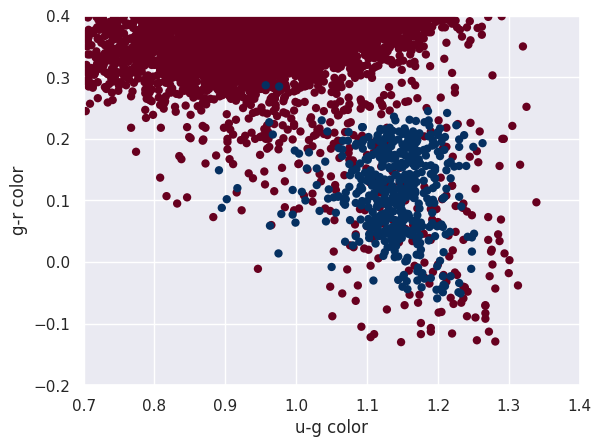

In [6]:
N_plot = 5000
plt.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:],
            edgecolors='none', cmap='RdBu')
plt.xlabel('u-g color')
plt.ylabel('g-r color')
plt.xlim(0.7, 1.4)
plt.ylim(-0.2, 0.4);

Blue points are RR-Lyrae, Red points are main sequence stars.

### Classification Exercise

Let's take a look at the Support Vector Classifier, ``sklearn.svm.SVC``:

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred,
                            target_names=['MS star', 'RR Lyrae']))

              precision    recall  f1-score   support

     MS star       1.00      1.00      1.00     23182
    RR Lyrae       0.00      0.00      0.00       104

    accuracy                           1.00     23286
   macro avg       0.50      0.50      0.50     23286
weighted avg       0.99      1.00      0.99     23286



/home/sampersie/.venvs/jvp_stats_2014/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sampersie/.venvs/jvp_stats_2014/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sampersie/.venvs/jvp_stats_2014/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [8]:
y_test.shape

(23286,)

OK... this is not too good. With the default parameters, SVC labels *everything* a main sequence star. This is 99% accurate, but we don't identify any of the RR Lyraes! Zero contamination, but also zero completeness.

After reading around on the [scikit-learn website](http://scikit-learn.org), we might notice that there is a ``class_weight`` parameter to the SVC. Let's try setting this to ``"auto"``:

In [10]:
clf = SVC(kernel='linear', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred,
                            target_names=['MS star', 'RR Lyrae']))

              precision    recall  f1-score   support

     MS star       1.00      0.96      0.98     23182
    RR Lyrae       0.11      1.00      0.19       104

    accuracy                           0.96     23286
   macro avg       0.55      0.98      0.59     23286
weighted avg       1.00      0.96      0.98     23286



Better! We find a recall of 99% for RR Lyrae stars: we now identify almost all of them, but at the expense of a lot of contamination (the precision tells us that only 11% of identified RR Lyrae are actual RR Lyrae stars).

We could adjust the ``C`` and ``gamma`` parameter to try to fine-tune this:

In [13]:
C_values = 10.0 ** np.linspace(-2, 2, 5)

for C in C_values:
    print("C = {0:.2e}".format(C))
    clf = SVC(kernel='linear', class_weight='balanced', C=C)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred,
                                target_names=['MS star', 'RR Lyrae']))
    

C = 1.00e-02
              precision    recall  f1-score   support

     MS star       1.00      0.97      0.98     23182
    RR Lyrae       0.12      0.99      0.22       104

    accuracy                           0.97     23286
   macro avg       0.56      0.98      0.60     23286
weighted avg       1.00      0.97      0.98     23286

C = 1.00e-01
              precision    recall  f1-score   support

     MS star       1.00      0.96      0.98     23182
    RR Lyrae       0.11      1.00      0.20       104

    accuracy                           0.96     23286
   macro avg       0.56      0.98      0.59     23286
weighted avg       1.00      0.96      0.98     23286

C = 1.00e+00
              precision    recall  f1-score   support

     MS star       1.00      0.96      0.98     23182
    RR Lyrae       0.11      1.00      0.19       104

    accuracy                           0.96     23286
   macro avg       0.55      0.98      0.59     23286
weighted avg       1.00      0.96  


C = 1.00e+02
             precision    recall  f1-score   support

    MS star       1.00      0.96      0.98     23148
   RR Lyrae       0.14      0.99      0.24       138

avg / total       0.99      0.96      0.98     23286


We see that the fit is **very** sensitive to the value of $\log(C)$ – this is a general trait of support vector machines. We'll see later in the cross-validation section how to more rigorously analyze what's going on with these sorts of hyperparameters.

## 2. Regression: Photometric Redshifts

The photometric redshift problem is a classic *Regression* problem

In [14]:
from astroML.datasets import fetch_sdss_specgals

In [15]:
data = fetch_sdss_specgals()

# put magnitudes in a matrix
X = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
y = data['z']

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
from sklearn.linear_model import LinearRegression
est = LinearRegression()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

(0.0, 0.6)

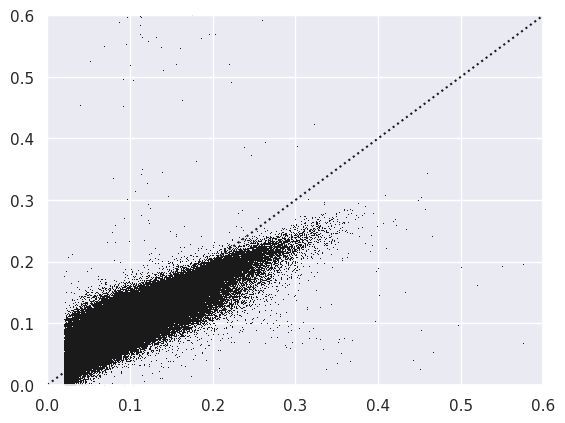

In [17]:
plt.plot(y_test, y_pred, ',k')
plt.plot([0, 1], [0, 1], ':k')
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

### Regression Exercise

Let's try this with the Random Forest Regressor.

For the sake of our sanity and the speed of calculation, we'll only look at 10% of the training data:

In [18]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train[::10], y_train[::10])
y_pred = model.predict(X_test)

rms = 0.02300928658937817


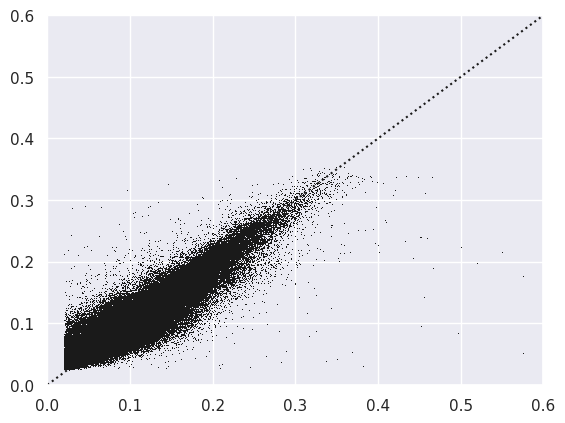

In [19]:
plt.plot(y_test, y_pred, ',k')
plt.plot([0, 1], [0, 1], ':k')
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

print("rms = {0}".format(np.sqrt(np.mean((y_test - y_pred) ** 2))))

This is a better RMS (and, by-eye, a much better fit) than we saw above with the simple linear regression.

Let's see how the rms changes as we change the depth of the trees:

In [20]:
max_depths = np.arange(1, 20)
rms_values = []
for max_depth in max_depths:
    model = RandomForestRegressor(random_state=0, max_depth=max_depth)
    model.fit(X_train[::10], y_train[::10])
    y_pred = model.predict(X_test)
    rms_values.append(np.sqrt(np.mean((y_test - y_pred) ** 2)))

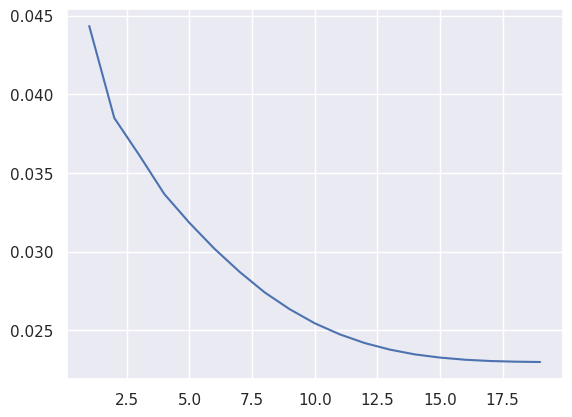

In [21]:
plt.plot(max_depths, rms_values);

Apparently using a large max_depth leads to a better rms! But we should be careful here: as max_depth gets larger, our tendency to over-fit the data also becomes larger.